In [1]:
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Carregar os dados

In [2]:
df = pd.read_csv("../datasets/raw/gender_classification_v7.csv")
df.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,Male
1,0,14.0,5.4,0,0,1,0,Female
2,0,11.8,6.3,1,1,1,1,Male
3,0,14.4,6.1,0,1,1,1,Male
4,1,13.5,5.9,0,0,0,0,Female


## Dividir dados em treino e teste

In [3]:
y = df.iloc[::, -1].map({'Female': 0, 'Male': 1})
X = df.iloc[::, :-1:]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_test = y_test.values.reshape((y_test.shape[0], 1))

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4000, 7), (4000,), (1001, 7), (1001, 1))

## Normalizar dados

In [4]:
min_max_scaler = MinMaxScaler()

x_train_scaled = min_max_scaler.fit_transform(x_train)
x_test_scaled = min_max_scaler.transform(x_test)

## Criar modelo FeedForward

In [5]:
def model_feed_forward():
    model = Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape=(7,)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return model

model = model_feed_forward()
history = model.fit(x_train_scaled, y_train, epochs=20, batch_size=10, validation_data=(x_test_scaled, y_test))
_, accuracy = model.evaluate(x_test_scaled, y_test, batch_size = 10)

print(f"FeedForward Accuracy: {round(100.0 * accuracy, 3)}%")

Epoch 1/20
400/400 [==============================] - 0s 924us/step - loss: 0.3146 - accuracy: 0.9133 - val_loss: 0.1287 - val_accuracy: 0.9560
Epoch 2/20
400/400 [==============================] - 0s 585us/step - loss: 0.1215 - accuracy: 0.9528 - val_loss: 0.0899 - val_accuracy: 0.9580
Epoch 3/20
400/400 [==============================] - 0s 525us/step - loss: 0.1010 - accuracy: 0.9605 - val_loss: 0.0807 - val_accuracy: 0.9590
Epoch 4/20
400/400 [==============================] - 0s 535us/step - loss: 0.0947 - accuracy: 0.9607 - val_loss: 0.0754 - val_accuracy: 0.9620
Epoch 5/20
400/400 [==============================] - 0s 556us/step - loss: 0.0903 - accuracy: 0.9640 - val_loss: 0.0697 - val_accuracy: 0.9660
Epoch 6/20
400/400 [==============================] - 0s 531us/step - loss: 0.0876 - accuracy: 0.9663 - val_loss: 0.0664 - val_accuracy: 0.9690
Epoch 7/20
400/400 [==============================] - 0s 586us/step - loss: 0.0848 - accuracy: 0.9663 - val_loss: 0.0697 - val_accuracy:

## Visualizar perda de treino e teste do modelo FeedForward

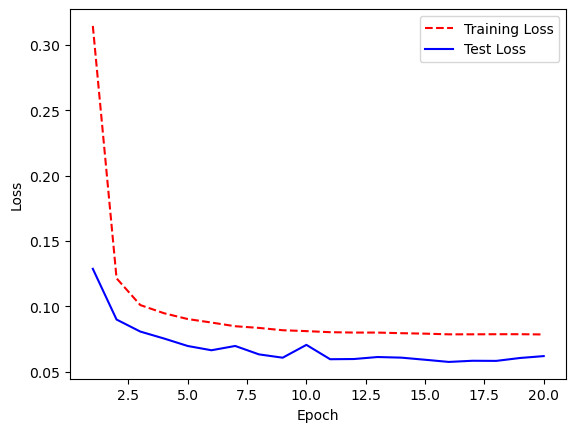

In [6]:
# Get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Criar modelos KNeighbors e Random Forest

In [7]:
def evaluate_model(model, model_name):
    model = model()
    
    model.fit(x_train_scaled, y_train)
    #y_hat = model.predict(x_test_scaled)
    score = round(model.score(x_test_scaled, y_test)* 100, 3)
    
    print(f"{model_name} Accuracy: {score}%")

evaluate_model(KNeighborsClassifier, "KNeighnors")
evaluate_model(RandomForestClassifier, "Random Forest")

KNeighnors Accuracy: 97.203%
Random Forest Accuracy: 97.802%
